In [1]:
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)
from PIL import Image
import numpy as np
from scipy.misc import comb
from math import log, exp, sqrt
import seaborn as sns
# sns.set_context("paper")
sns.set_context('talk')
import string
import json

%matplotlib inline

In [39]:
dist = 1 - np.sort(np.random.rand(30))

In [2]:
def smooth(dist, tau):
    return np.exp(dist / tau)

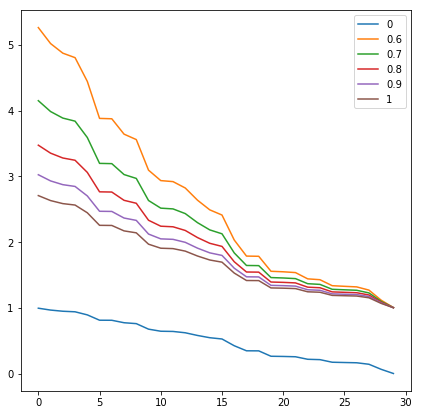

In [41]:
f, axs = plt.subplots(1, 1, figsize=(7, 7))
axs.plot(dist, label=0)
for tau in [0.6, 0.7, 0.8, 0.9, 1]:
    axs.plot(smooth(dist, tau), label=tau)
axs.legend()


In [21]:
print(dist)

[ 0.00752433  0.01563088  0.03044876  0.0619623   0.09322863  0.09544672
  0.11626237  0.11884322  0.12253128  0.12592348  0.12945606  0.1703686
  0.18707797  0.35567745  0.38075509  0.38334457  0.38844391  0.47788503
  0.48538138  0.5088568   0.51974281  0.532293    0.61576223  0.64020407
  0.66282104  0.68434053  0.74069251  0.80031864  0.93916653  0.9394426 ]


In [3]:
def distrib(m, v, tau=0.7):
    x = [comb(m, d, exact=False) * (v-1)**d / v**m * exp(-d/tau) for d in range(m+1)]
    x = np.array(x)
    x/= np.sum(x)
    return x

In [21]:
A = distrib(16, 400, tau=0.1)

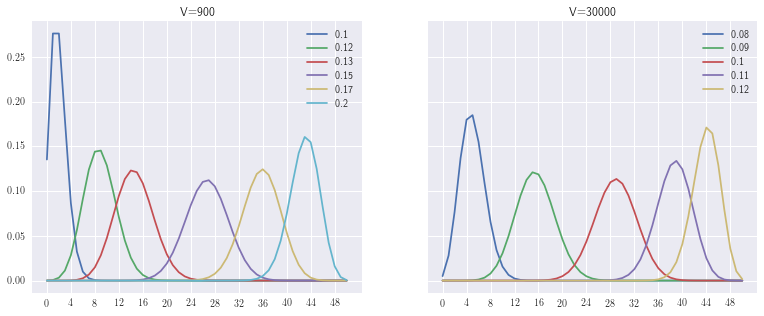

In [17]:
# m = 16
# V1 = 180
# V2 = 9800

m = 50
V1 = 900
V2 = 30000
sns.set()
fig, axs = plt.subplots(1, 2, figsize=(13, 5), sharey=True)
for tau in [0.1, 0.12, 0.13, .15, 0.17 ,.2]:
    axs[0].plot(range(m+1) , distrib(m, V1, tau), label=tau)
axs[0].legend()
axs[0].set_xticks(4 * np.arange(m//4 +1))
axs[0].set_title('V=%d'% V1)

for tau in [0.08, 0.09, .1, 0.11 ,.12]:
    axs[1].plot(range(m+1) , distrib(m, V2, tau), label=tau)
axs[1].legend()
axs[1].set_xticks(4 * np.arange(m//4 +1))
axs[1].set_title('V=%d' % V2)
plt.savefig('../figures/hamming_q_m%d.png' % m, dpi=400, bbox_inches='tight')

([<matplotlib.axis.XTick at 0x7f89154ea198>,
 <a list of 5 Text xticklabel objects>)

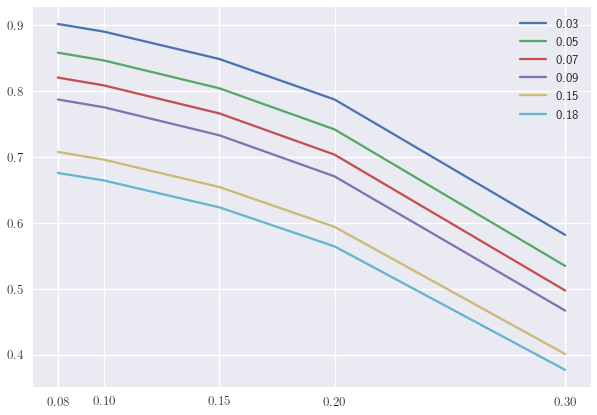

In [105]:
# Substiting rare n-grams decrease the similariy more
# if I inject a rare n-gram the similariy decrease more
x = np.array([.08, .1, .15, .2, .3])
R = np.sum(x**2)
plt.figure(figsize=(10, 7))
for pick in [.03, .05, .07, .09, .15, .18]:
    sim = [(R - xx**2) / (sqrt(R) * sqrt(R - xx**2 + pick)) for xx in x ]
    plt.plot(x, sim, label=pick)
plt.legend()
# plt.xticks(x)

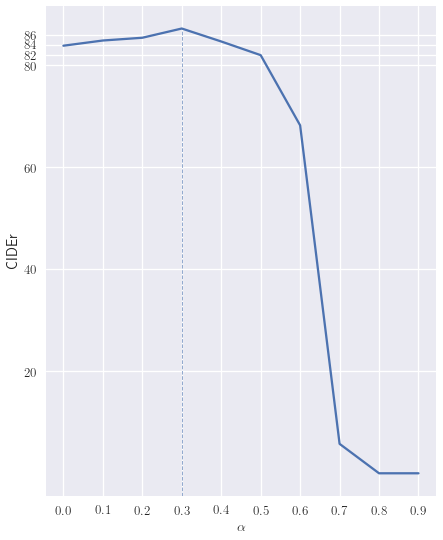

In [63]:
# CST reward plot:
alphas = np.arange(10)/ 10
CIDErs = np.array([83.82, 84.84, 85.38, 87.19, 84.65, 81.97, 68.21, 5.77, 0.0, 0.0])
plt.figure(figsize=(7, 9))
plt.plot(alphas, CIDErs)
plt.axvline(x=0.3, ymin=0, ymax=.95, linewidth=1, linestyle='--', alpha=0.6)
plt.xticks(alphas)
plt.yticks([20, 40, 60, 80, 82, 84, 86])
plt.xlabel(r'$\alpha$')
plt.ylabel('CIDEr')
plt.savefig('../figures/constant_R.png', dpi=400, bbox_inches='tight')

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9])

In [3]:
df = pickle.load(open('../data/coco-train-tok-df.p', 'rb'))

In [4]:
df = df['freq']

In [5]:
ngrams = list(df)

In [10]:
labels = json.load(open('../data/coco/cocotalk.json', 'r'))

In [12]:
labels = labels['ix_to_word']

In [13]:
wtoi = {}
for k in labels:
    wtoi[labels[k]] = int(k)

In [14]:
wtoi['an']

2597

In [15]:
G = {1: {}, 2: {}, 3: {}, 4: {}}
for k in ngrams:
    # print('ngram:', k)
    try:
        code = tuple(wtoi[kk.lower().translate(str.maketrans('','',string.punctuation))] for kk in k)
        # print("code:", code)
        G[len(k)][code] = df[k]
    except:
        pass

In [16]:
pickle.dump(G, open('../data/coco-train-tok-ng-df.p', 'wb'))

In [17]:
for k in G:
    print(k, len(G[k]))

1 9483
2 359754
3 1142377
4 1996852


TypeError: translate() takes exactly one argument (2 given)

In [23]:
freqs= {}
for k in G:
    freqs[k] = sorted([1/c for c in list(G[k].values())])

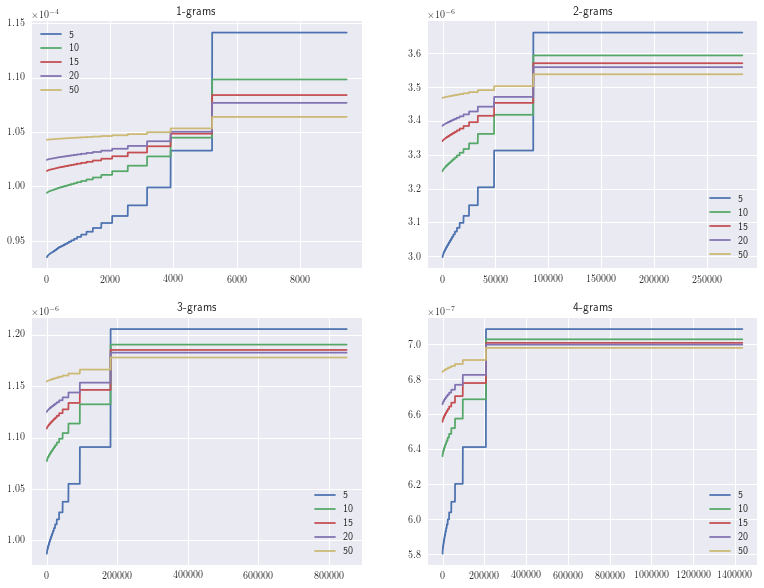

In [51]:
sns.set()
f, axs = plt.subplots(2, 2, figsize=(13,10))
axs = [a for ax in axs for a in ax]
for k in (1, 2, 3, 4):
    # axs[k-1].plot(np.arange(len(freqs[k])), freqs[k], label=0)
    for tau in (5, 10, 15, 20, 50):
        v = np.array([exp(f/tau) for f in freqs[k]])
        v /= np.sum(v)
        axs[k-1].plot(np.arange(len(freqs[k])), v , label=tau)
    axs[k-1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    axs[k-1].legend()
    axs[k-1].set_title('%d-grams' % k)
plt.savefig('../figures/freq_tfidf.png', dpi=400, bbox_inches='tight')